In [1]:
#Imports
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Read in data
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df.head(3)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0


<Axes: title={'center': 'PJME East Energy Plot'}, xlabel='Datetime'>

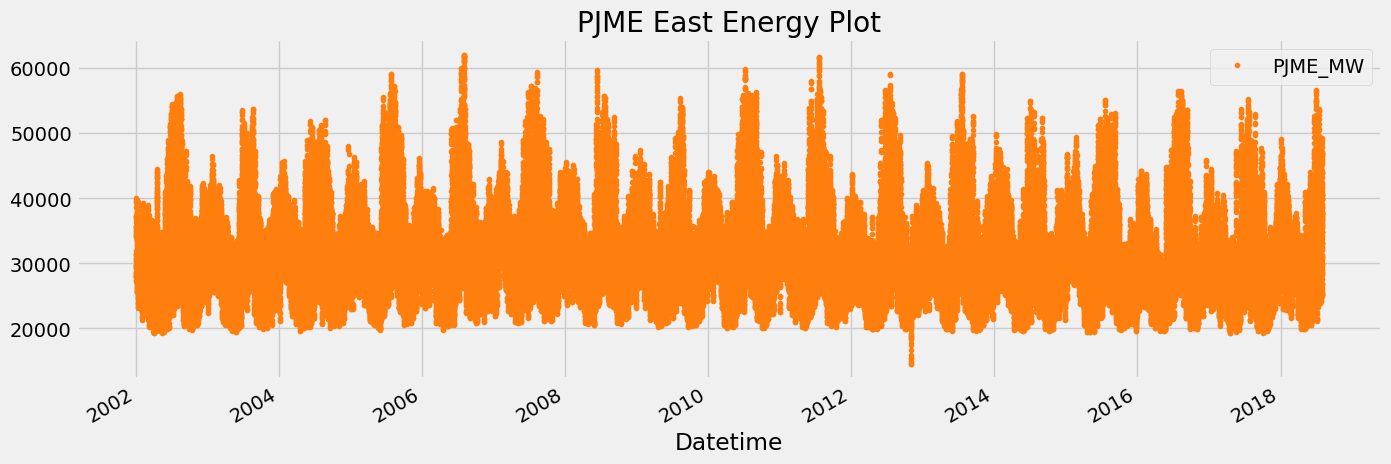

In [3]:
#Format index
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.plot(style='.', figsize=(15,5), color=color_pal[1], title='PJME East Energy Plot')

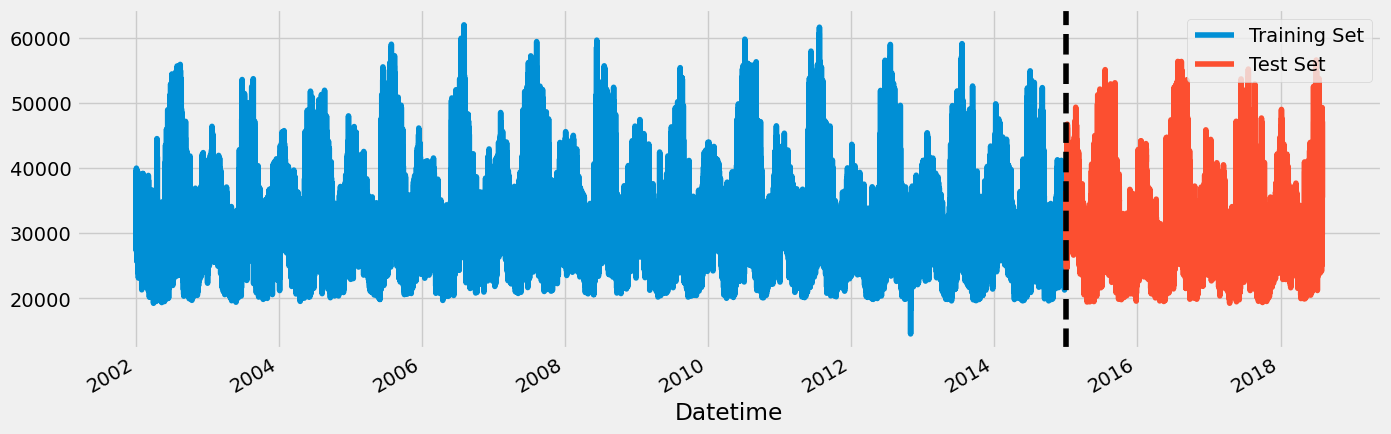

In [4]:
# Train-test-split
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training Set')
test.plot(ax=ax, label = 'Test Set')
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [5]:
#Feature creation function
def create_features(df):
    #Creates time series features based off of time series indices
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

<function matplotlib.pyplot.show(close=None, block=None)>

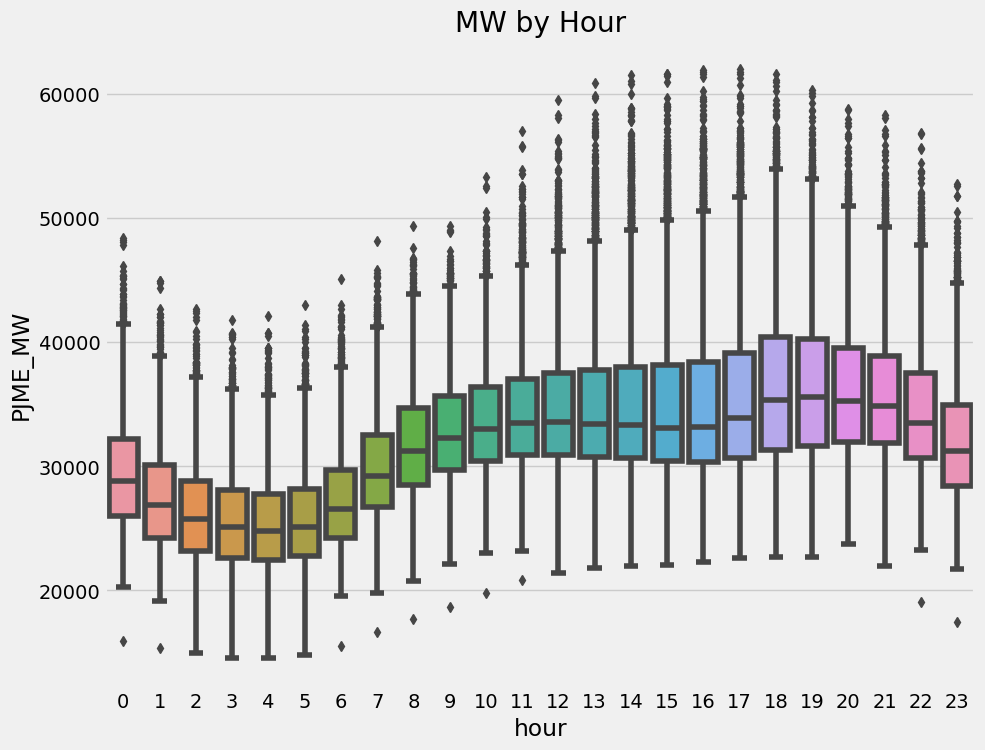

In [6]:
#Visualize feature/target relationship (by hour)
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

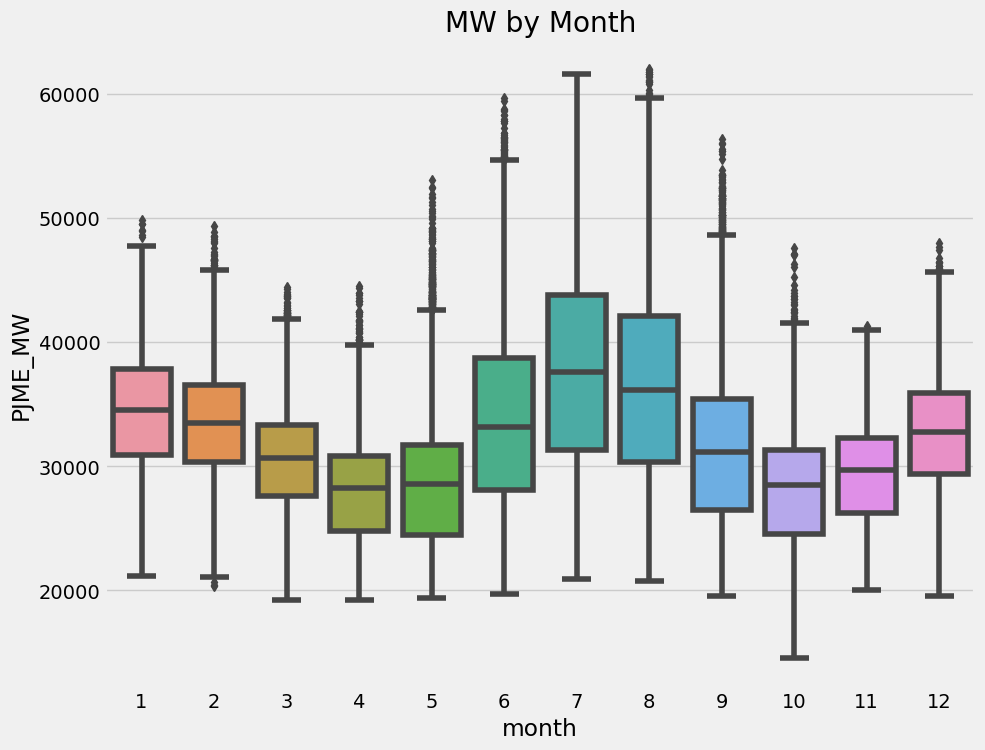

In [7]:
#Plot by month
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x = 'month', y = 'PJME_MW')
ax.set_title('MW by Month')
plt.show

In [8]:
#Model Creation
train = create_features(train)
test = create_features(test)

features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
target = 'PJME_MW'

x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [9]:
#Build and run the model
reg = xgb.XGBRegressor(n_estimators = 500, early_stopping_rounds = 20,
                       learning_rate = 0.01)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], 
         verbose = True)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[1]	validation_0-rmse:32279.88735	validation_1-rmse:31332.60350
[2]	validation_0-rmse:31961.14360	validation_1-rmse:31014.27357
[3]	validation_0-rmse:31645.62525	validation_1-rmse:30699.10021
[4]	validation_0-rmse:31333.30788	validation_1-rmse:30385.92606
[5]	validation_0-rmse:31024.14316	validation_1-rmse:30075.82644
[6]	validation_0-rmse:30718.10796	validation_1-rmse:29769.05547
[7]	validation_0-rmse:30415.17979	validation_1-rmse:29465.13991
[8]	validation_0-rmse:30115.31200	validation_1-rmse:29164.62813
[9]	validation_0-rmse:29818.48171	validation_1-rmse:28866.85195
[10]	validation_0-rmse:29524.66621	validation_1-rmse:28571.74321
[11]	validation_0-rmse:29233.82326	validation_1-rmse:28280.36822
[12]	validation_0-rmse:28945.84624	validation_1-rmse:27991.28725
[13]	validation_0-rmse:28660.79477	validation_1-rmse:27705.25177
[14]	validation_0-rmse:28378.63482	validation_1-rmse:27422.93837
[15]	validation_0-rmse:28099.33236	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

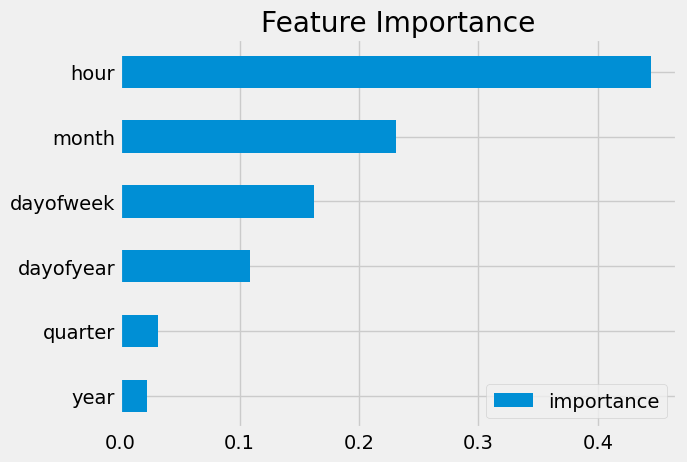

In [10]:
# Feature Importance
fi = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_,
             columns = ['importance'])
fi.sort_values('importance').plot(kind='barh', title = 'Feature Importance')
plt.show()

In [11]:
#Forecasting

test['prediction'] = reg.predict(x_test)
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

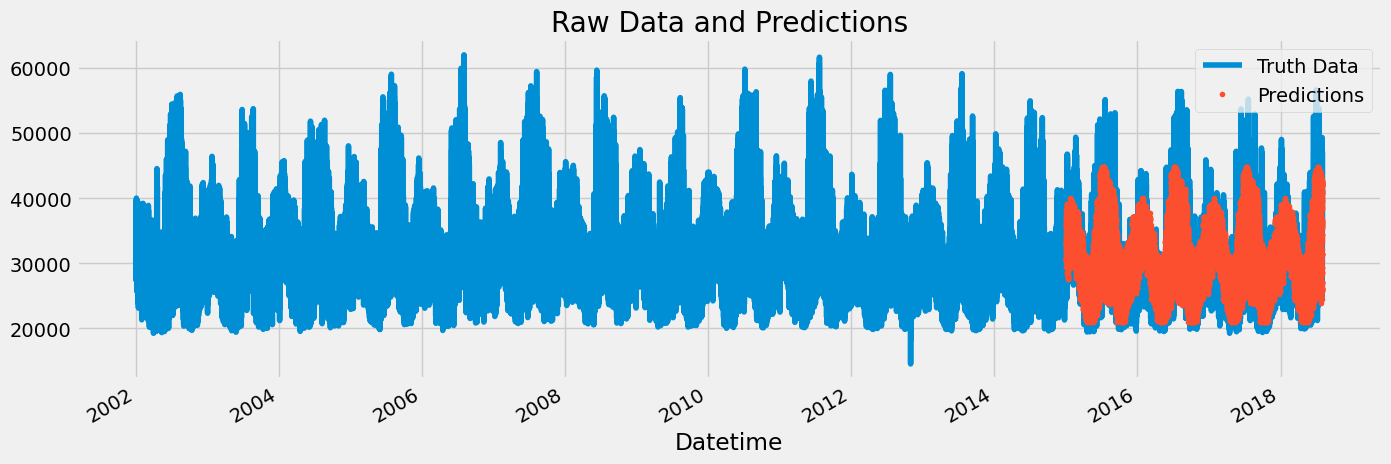

In [12]:
#Plotting predictions against real values
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

In [13]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print('RMSE Score on the Test set:', score)

RMSE Score on the Test set: 3715.9314164142415


In [14]:
#Calculating error
test['error'] = np.abs(test[target] - test['prediction'])

#Look at worst days
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

In [15]:
#Look at best days
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64

Looking Forward:
-Implement more robust cross validation
-Add more features (weather forecast, holidays, etc.)